#### Last Modified: August 5th, 2022 (Opal). 

# sOpInf applied to the Inviscid Burgers' Equation (Example #1)

In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/oissan/PycharmProjects/Space-Weather-ROM-Revised'

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import rom_operator_inference as roi
import scipy 
from scipy import stats
import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

### Shifted Operator Inference (sOpInf) Applied to the Invisicid Burgers Equation
The one-dimensional invisicid Burgers' equation is of the form:

\begin{equation} \label{inviscid-burgers-equation}
    \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0
\end{equation}

subject to the initial condition $u(x, t=0)=u_{0}(x)$ with boundary conditions at $x=a$ and $x=b$. In the moving coordinate frame, $u(x, t) = \tilde{u} (x + c(t), t)$, Eq. above becomes 

\begin{equation}\label{shifted-inviscid-burgers-equation}
\frac{\partial \tilde{u}}{\partial t} + \left(\tilde{u} + \frac{dc}{dt}\right) \frac{\partial \tilde{u}}{\partial \tilde{x}} = 0
\end{equation}

which can be written in conservative form as

\begin{equation}\label{shifted-burgers-conservative}
\frac{\partial \tilde{u}}{\partial t} +  \frac{\partial}{\partial \tilde{x}}\left[g(\tilde{u})\right] = 0
\end{equation}

with $g(\tilde{u}) = \frac{1}{2}\tilde{u}^2 + \frac{dc}{dt} \tilde{u}$. Then, by the conservative first-order upwind scheme, we approximate the derivative of the flux function $g$ with respect to $\tilde{x}$ by

\begin{equation} \label{conservative-upwind-scheme-burgers}
    \frac{\partial}{\partial \tilde{x}} [g(\tilde{u})] \approx \frac{1}{\Delta \tilde{x}}  \{g[\tilde{u}(\tilde{x}_{j+1}, t)] - g[\tilde{u}(\tilde{x}_{j}, t)]\}
\end{equation}

where $j$ denotes the grid index in $\tilde{x}$. In vector form, we can write the dynamics in quadratic form:

\begin{equation} \label{shifted-burgers-vector-form-quad}
\frac{d\mathbf{\tilde{u}}}{d t} = \mathbf{H} (\mathbf{\tilde{u}} \otimes \mathbf{\tilde{u}}) + \mathbf{A}(t) \mathbf{\tilde{u}}
\end{equation}

where $\otimes$ denotes the Kronecker product and  $\mathbf{\tilde{u}} = [\mathbf{\tilde{u}}(\tilde{x}_{1}, t), \mathbf{\tilde{u}}(\tilde{x}_{2}, t), ..., \mathbf{\tilde{u}}(\tilde{x}_{n}, t)]^{\top} \in \mathbb{R}^{n}$ is the state vector discretized over $n$ spatial points at time $t$. The operator $\mathbf{A}(t) \in \mathbb{R}^{n \times n}$ is the linear operator and $\mathbf{H} \in \mathbb{R}^{n \times n^2}$ is the quadratic operator. If $c(t)$ is linear, meaning the wave is traveling in constant speed, then the linear operator $\mathbf{A}(t) = \mathbf{A}$ does not depend on time. Given the FOM is in polynomial form, Operator Inference can maintain the same polynomial structure in the  low-dimensional basis with high accuracy.


### Shifted Operator Inference (sOpInf) from noisy data
Assume the snapshot dataset is given from noisy messurements where 
$$
\mathbf{u}_{i, j}^{\text{noise}} = \mathbf{u}_{i, j} + \mathbf{\xi}_{i, j}
$$

where $\mathbf{\xi}_{i, j}$ are random independent variables that represent noise where $\mathbf{\xi}_{i, j} \sim \mathcal{N}(0, \sigma^2)$. 

### Set Rectangular Computational Grid Size

In [4]:
# number of mesh points in the T (time) axis. 
m = 1000
# number of mesh points in X (spatial) axis. 
n = 500
# final time. 
T = 2
# boundary of x [a, b].
a = 0
b = 3

In [5]:
# time and spatial grid (uniform spacing).
t_vec = np.linspace(0, T, m)
x_vec = np.linspace(a, b, n)[:-1]

### Set Initial Condition

In [6]:
# gaussian initial condition
initial_condition = 0.8 +  0.5*np.exp(-(x_vec - 1)**2/(0.1))

### Numerical Solution via Finite Differencing

We solve the inviscid Burgers' equation via the first-order finite difference upwind scheme with forward Euler 
$$
u_{j}^{n+1} = u_{j}^{n} - \frac{\Delta t}{2\Delta x} \left( (u^{n}_{j})^{2} - (u^{n}_{j-1})^{2} \right)
$$


In [7]:
# flux function
def flux(u): 
    return 0.5*(u**2)

def solve_upwind_scheme(initial_condition, t_vec, x_vec):
    """ solve a 1-d advection diffusion equation using the first order conservative upwind scheme"""
    U = np.zeros((len(x_vec), len(t_vec)))
    
    U[:, 0] = initial_condition
    
    dt = np.mean(t_vec[1:] - t_vec[:-1])
    dx = np.mean(x_vec[1:] - x_vec[:-1])
    
    for ii in range(len(t_vec)-1):
        for jj in range(len(x_vec)):
            if (U[jj, ii] * dt/dx) > 1:
                print("Warning: CFL condition violated. ")
                
            # update the next cell.
            U[jj, ii+1] = U[jj, ii] + (dt/dx)*(flux(U[jj-1, ii])  - flux(U[jj, ii]))
    return U

In [8]:
U_sol = solve_upwind_scheme(initial_condition, t_vec, x_vec)

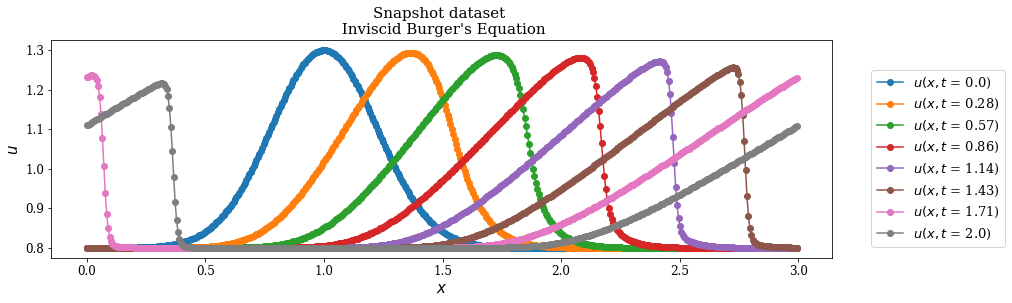

In [9]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.linspace(0, len(t_vec) -1, 8):
    ax.plot(x_vec, U_sol[:, int(ii)], "-o", label="$u(x, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Snapshot dataset \n Inviscid Burger's Equation", fontsize=15)
_ = ax.legend()
_ = ax.legend(loc=(1.05, .05))

# Gaussian noise to snapshots

We pollute with Gaussian noise proportional to the range of $u_{i, j}$, where $i,j$ denote the spatial and temporal discretization. The Gaussian noise, $\xi \sim \mathcal{N}(0, \nu^2)$ with $\nu = \zeta(\max_{i,j} u_{i, j} - \min_{i, j} u_{i, j}) = \zeta (1.3 - 0.8) = \zeta (0.5)$, the coefficient $\zeta$ is the noise level. 

In [10]:
# set seed 
np.random.seed(0)
# number of noise levels (zeta= 0, 1, 2, ... ).
num_of_noise = 21
# initialize the noise matrix. 
U_noise = np.zeros((len(x_vec), len(t_vec), num_of_noise))
# solve for noise levels. 
for ii in range(num_of_noise):
    noise_level = (ii)/100
    U_noise[:, :, ii] = U_sol + np.random.normal(scale=noise_level*0.5, size=np.shape(U_sol))

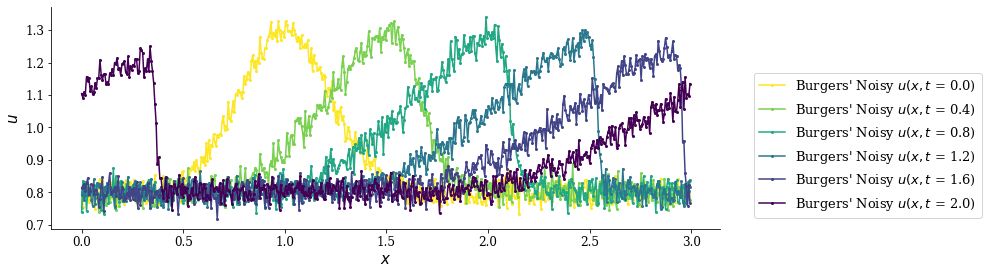

In [11]:
sample_columns = np.arange(0, len(t_vec), int(len(t_vec)//5))
sample_columns = np.append(sample_columns, len(t_vec) -1)
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

fig, ax = plt.subplots(figsize=(14, 4))
for ii in sample_columns:
    curr_color = next(color)
    ax.plot(x_vec, U_noise[:, int(ii), 5], "-o",markersize=2, c=curr_color, label="Burgers' Noisy $u(x, t$ = "+ str(round(t_vec[int(ii)], 1)) + ")")
    #ax.scatter(x_vec, U_noise[:, int(ii), 2],c=curr_color, s=10)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.legend()
_ = ax.legend(loc=(1.05, .05))
_ = ax.spines["right"].set_visible(False)
_ = ax.spines["top"].set_visible(False)
plt.tight_layout()
plt.savefig("Burgers/figs/burgers_noise.png", dpi=600)

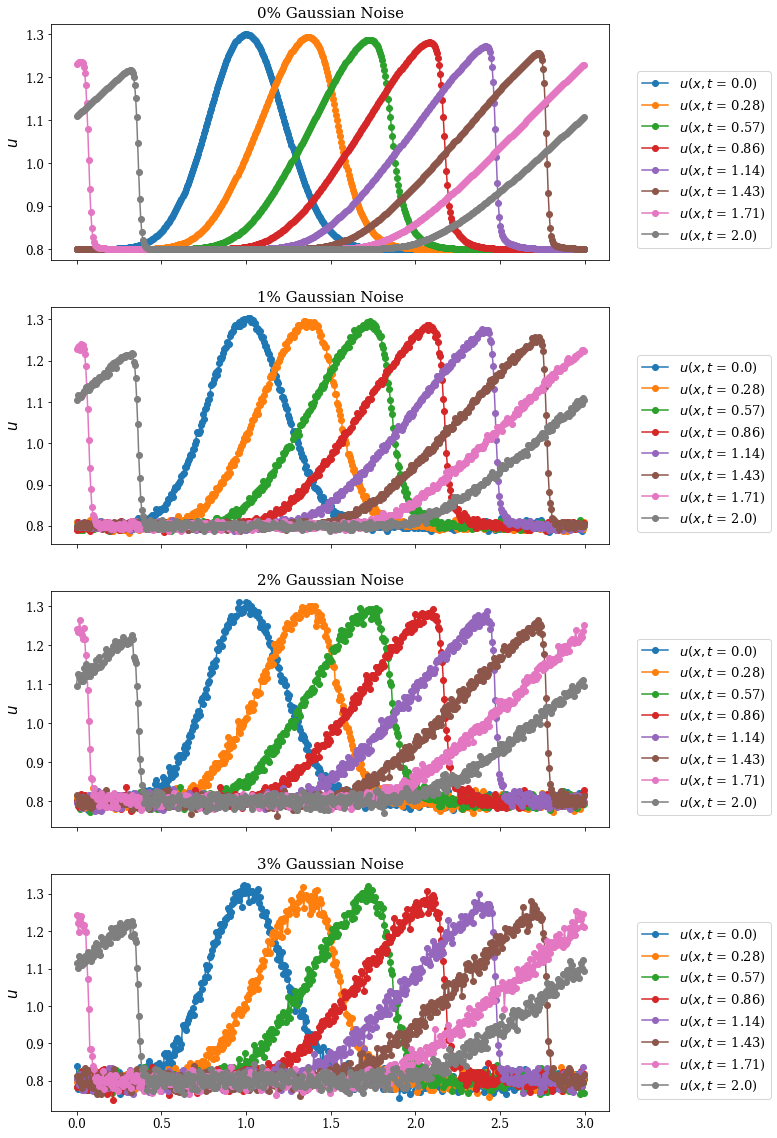

In [12]:
fig, ax = plt.subplots(nrows=num_of_noise//5, sharex=True, figsize=(10, 20))
for jj in np.arange(num_of_noise//5):
    for ii in np.linspace(0, len(t_vec) -1, 8):
        ax[jj].plot(x_vec, U_noise[:, int(ii), int(jj)], "-o", label="$u(x, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
    _ = ax[jj].set_ylabel("$u$", fontsize=15)
    _ = ax[jj].tick_params(axis='both', which='major', labelsize=12)
    _ = ax[jj].set_title(str(round(jj)) + "% Gaussian Noise", fontsize=15)
    _ = ax[jj].legend()
    _ = ax[jj].legend(loc=(1.05, .05))

## Compute the spatial shift function $c(t)$
### Method #1:  The Method of Characteristics (with shock capturing)

In [13]:
moc = np.zeros(len(t_vec))

### Method #2: Cross-Correlation Extrapolation Method

In [14]:
def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

In [15]:
# initialize shift function 
shift_vec = np.zeros((len(t_vec), num_of_noise))

for ii in range(1, len(t_vec)):
    for jj in range(num_of_noise):
        corr = periodic_corr_np(U_noise[:, ii, jj], U_noise[:, 0, jj])
        shift_vec[ii, jj] = (x_vec[np.argmax(corr)])

In [16]:
# training ends
n = int(len(t_vec)*0.8)

def func_linear(xi, t):
    return xi*t

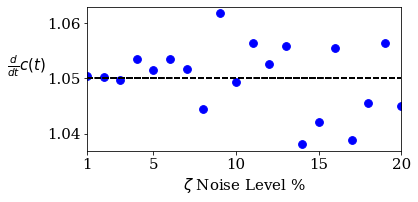

In [17]:
fig, ax = plt.subplots(figsize=(6, 3))
m_max = -np.inf
m_min = np.inf
for ii in range(num_of_noise):
    m_mean = scipy.optimize.curve_fit(func_linear, t_vec[:n], shift_vec[:n, ii])[0][0]
    if m_mean < m_min:
        m_min = m_mean
    if m_mean > m_max:
        m_max = m_mean
    _ = ax.scatter(ii+1, m_mean,c="b",  label="$\zeta$= " + str(round(ii)) + "% Noise Level", s=60)
    _ = ax.axhline(1.05, ls="--", c="k")
    _ = ax.set_xlim(1, 20)
    _ = ax.set_xticks([1, 5, 10, 15, 20])
    _ = ax.set_xlabel("$\zeta$ Noise Level %", fontsize=15)
    _ = ax.set_ylabel(r"$\frac{d}{d t} c(t)$",  rotation=0, labelpad=20, fontsize=15)
plt.tight_layout()
plt.savefig("Burgers/figs/noise_c_t_robust.png", dpi=100)

In [18]:
print(np.abs(m_max-1.05))
print(np.abs(m_min-1.05))

0.011798149255314305
0.011927295685054018


In [19]:
def c_t(t_idx, t_vec, xi, method):
    if method=="moc":
        return np.loadtxt('Burgers/shock_curve.csv', delimiter=',')[t_idx]
    if method=="cce":
        return t_vec[t_idx]*xi

In [22]:
# chosen level of noise
zeta = 5
m_mean_1 = scipy.optimize.curve_fit(func_linear, t_vec[:n], shift_vec[:n, zeta])[0][0]
m_mean_0 = scipy.optimize.curve_fit(func_linear, t_vec[:n], shift_vec[:n, 0])[0][0]

In [23]:
# shift all snapshots by c(t) 
U_new = np.zeros(U_sol.shape)
U_new[:, 0] = U_noise[:, 0, zeta]

U_sol_shifted = np.zeros(U_sol.shape)
U_sol_shifted[:, 0] = U_sol[:, 0]


for ii in range(1, len(t_vec)):
    shift= c_t(t_idx=ii, t_vec=t_vec, method="cce", xi=m_mean_1) 
    U_new[:, ii] = np.interp(x_vec + shift, x_vec, U_noise[:, ii, zeta], period=b) 
    
    shift= c_t(t_idx=ii, t_vec=t_vec, method="cce", xi=m_mean_0) 
    U_sol_shifted[:, ii] = np.interp(x_vec + shift, x_vec, U_sol[:, ii], period=b) 

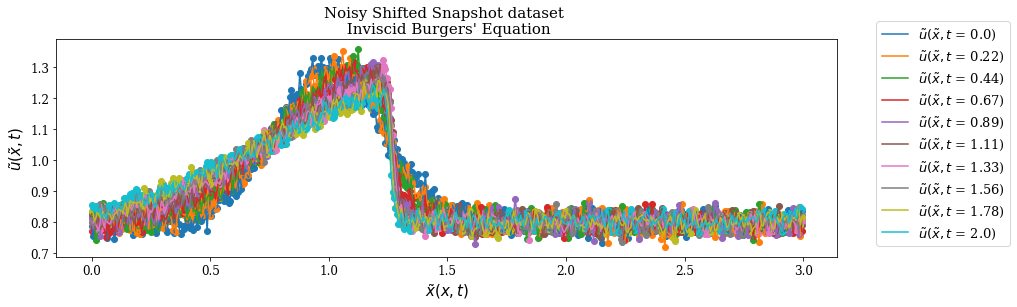

In [24]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.linspace(0, len(t_vec) -1, 10):
    ax.plot(x_vec, U_new[:, int(ii)], "-", label=r"$\tilde{u}(\tilde{x}, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
    ax.scatter(x_vec, U_new[:, int(ii)])
_ = ax.legend(loc=(1.05, .05))
#_ = ax.set_xlim(1.2, 1.4)
_ = ax.set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
_ = ax.set_ylabel(r"$\tilde{u}(\tilde{x}, t)$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Noisy Shifted Snapshot dataset \n Inviscid Burgers' Equation", fontsize=15)

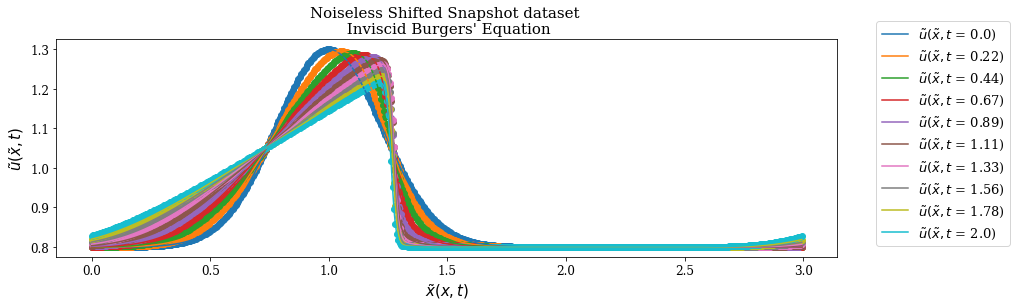

In [25]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.linspace(0, len(t_vec) -1, 10):
    ax.plot(x_vec,U_sol_shifted[:, int(ii)], "-", label=r"$\tilde{u}(\tilde{x}, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
    ax.scatter(x_vec, U_sol_shifted[:, int(ii)])
_ = ax.legend(loc=(1.05, .05))
#_ = ax.set_xlim(1.2, 1.4)
_ = ax.set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
_ = ax.set_ylabel(r"$\tilde{u}(\tilde{x}, t)$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Noiseless Shifted Snapshot dataset \n Inviscid Burgers' Equation", fontsize=15)

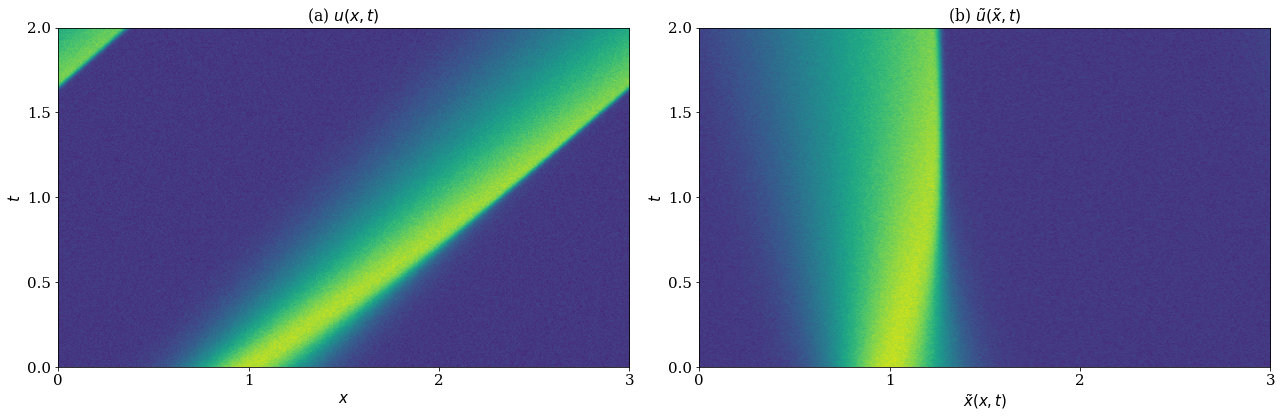

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(18, 6))
ax[0].imshow(U_noise[:, :, zeta].T, extent=[a,b, 0, T], aspect="auto", origin="lower")
ax[1].imshow(U_new.T, extent=[a,b, 0, T],  aspect="auto", origin="lower")

ax[0].set_xlabel(r"$x$", fontsize=15)
ax[1].set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
ax[0].set_ylabel(r"$t$", fontsize=15)
ax[1].set_ylabel(r"$t$", fontsize=15)
ax[0].set_title(r"(a) $u(x, t)$")
ax[1].set_title(r"(b) $\tilde{u}(\tilde{x}, t)$")

ax[0].set_xticks([0, 1, 2, 3])
ax[0].set_yticks([0, 0.5, 1, 1.5, 2])
ax[1].set_xticks([0, 1, 2, 3])
ax[1].set_yticks([0, 0.5, 1, 1.5, 2])

plt.tight_layout()

#plt.savefig("Burgers/figs/burgers_eqn_comparison_of_methods_to_compute_shift.png", dpi=500)

### Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [27]:
# set up the first l indexes used for training. 
l = int(0.8*(len(t_vec)))

In [28]:
X= U_new

In [29]:
X_train = X[:, :l]
X_test = X[:, l:-1]

In [30]:
t_train = t_vec[:l]
t_test = t_vec[l:-1]

In [31]:
print("U train shape", np.shape(X_train))
print("Time Interval train: " + str(t_vec[0]) + " to " + str(t_vec[l]))
print("\nU test shape", np.shape(X_test))
print("Time Interval test: " + str(t_vec[l]) + " to " + str(t_vec[-1]))

U train shape (499, 800)
Time Interval train: 0.0 to 1.6016016016016015

U test shape (499, 199)
Time Interval test: 1.6016016016016015 to 2.0


## Using the ROM Operator Inference Package


### Choosing the reduced-model dimension
A simple choice for the reduced basis is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and evaluated their cumulative energy. 
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [32]:
# compute the singular value decomposition
# original coordinates
svdvals_orig_noise = la.svdvals(U_noise[:, :l, zeta])
svdvals_orig_noiseless = la.svdvals(U_sol[:, :l])


# shifted coordinates
svdvals_shifted_noise = la.svdvals(X_train)
svdvals_shifted_noiseless = la.svdvals(U_sol_shifted[:, :l])

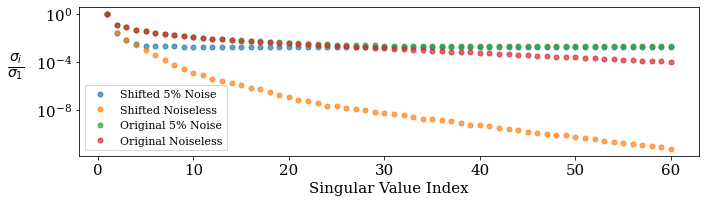

In [33]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(10, 3))
#plot singluar values cumulative energy
n_sig = 60
ax.plot(np.arange(1, n_sig+1), svdvals_shifted_noise[:n_sig]/svdvals_shifted_noise[0], ".", ms=10, lw=1, alpha=0.7, zorder=3, label="Shifted " + str(zeta) +"% Noise")
ax.plot(np.arange(1, n_sig+1), svdvals_shifted_noiseless[:n_sig]/svdvals_shifted_noiseless[0], ".", ms=10, alpha=0.7, lw=1, zorder=3,  label="Shifted Noiseless")
ax.plot(np.arange(1, n_sig+1), svdvals_orig_noise[:n_sig]/svdvals_orig_noise[0], '.', ms=10, lw=1, zorder=3, alpha=0.7, label="Original " + str(zeta) +"% Noise")
ax.plot(np.arange(1, n_sig+1), svdvals_orig_noiseless[:n_sig]/svdvals_orig_noiseless[0], '.', ms=10, lw=1, alpha=0.7, zorder=3, label="Original Noiseless")
ax.set_yscale("log")
plt.legend(loc='lower left', fontsize=11)
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\frac{\sigma_{i}}{\sigma_{1}}$", fontsize=20, rotation=0, labelpad=20)
#_ = ax.set_title("Singular Value Decay", fontsize=15)
plt.tight_layout()
plt.savefig("Burgers/figs/singular_value_decay_noise.png", dpi=700)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined. If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [34]:
rank= 4
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (499, 4)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

In [35]:
def normalize(vector):
    return (vector)/np.max(np.abs(vector))

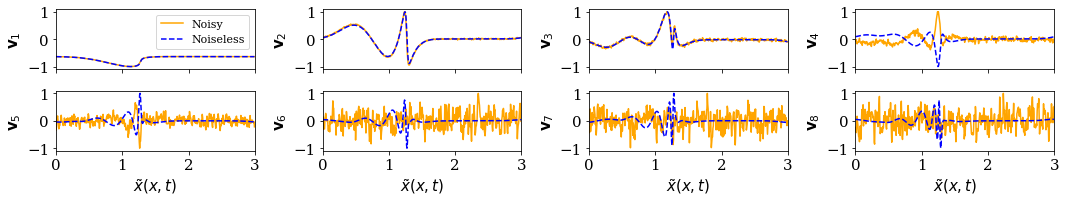

In [36]:
fig, ax = plt.subplots(ncols=4,nrows=2, sharex=True, figsize=(15, 3))

Vr_plot, _ = roi.pre.pod_basis(X_train, 8, mode="dense")
Vr_noiseless, _ = roi.pre.pod_basis(U_sol_shifted[:, :l], 8, mode="dense")
for ii in range(8):
    if ii < 4:
        jj = 0 
        ii_idx = ii
    else: 
        jj = 1
        ii_idx = ii - 4
        ax[jj, ii_idx].set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
    ax[jj, ii_idx].plot(x_vec, normalize(Vr_plot[:,ii]), c="orange", label="Noisy")
    ax[jj, ii_idx ].plot(x_vec, normalize(Vr_noiseless[:,ii]), "--", c="blue", label="Noiseless")
    ax[jj, ii_idx ].set_ylabel(r"$\mathbf{v}_{" + str(ii+1) + "}$", fontsize=15)
    ax[jj, ii_idx ].set_xlim(0, 3)
    ax[jj, ii_idx ].set_yticks([-1, 0, 1])
    ax[jj, ii_idx ].set_ylim(-1.1, 1.1)
    

ax[0, 0].legend(fontsize=11)
plt.tight_layout()
plt.savefig("Burgers/figs/pod_modes_noise.png", dpi=700)

In [37]:
def convert_from_x_to_v(X_ROM, b=3):
    """ convert the ROM results back to the original coordinates. (extrapolating c(t))"""
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    for jj in range(1, len(t_vec)):
        shift = c_t(jj, t_vec, method="cce", xi=m_mean_1)
        V_ROM[:, jj] = np.interp(x_vec - shift, x_vec, X_ROM[:, jj], period=b) 
    return V_ROM

In [38]:
def regularizer(r, λ1, λ2):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.

    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 = 1 + r
    r2 = r + r*(r + 1)//2
    diag𝚪 = np.full(r2, λ1)
    diag𝚪[r1:-1] = λ2
    return diag𝚪

# Quadratic-Linear ROM $\dot{\hat u} = \hat{A} \hat{u} + \hat{H} (\hat{u} \otimes \hat{u})$

In [39]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
Xproj = Vr.T  @ X_train

In [40]:
Vr_noiseless, _ = roi.pre.pod_basis(U_sol_shifted[:, :l], rank, mode="dense")
Xproj_noiseless = Vr_noiseless.T @ U_sol_shifted[:, :l]
Xdot_noiseless = roi.pre.xdot(Xproj_noiseless, t_vec[1]-t_vec[0], order=6) 

In [41]:
Xproj.shape

(4, 800)

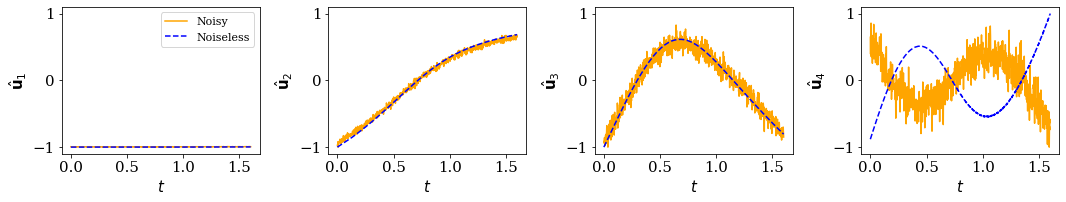

In [42]:
fig, ax = plt.subplots(ncols=rank, sharex=True, figsize=(15, 3))
for ii in range(rank):
    ax[ii].plot(t_vec[:l], normalize(Xproj[ii, :]), c="orange", label="Noisy")
    ax[ii].plot(t_vec[:l], normalize(Xproj_noiseless[ii, :]), c="blue", ls="--", label="Noiseless")
    ax[ii].set_ylabel(r"$\hat{\mathbf{u}}_{" + str(ii+1) +"}$", fontsize=15)
    ax[ii].set_yticks([-1, 0, 1])
    ax[ii].set_xticks([0, 0.5, 1, 1.5])
    ax[ii].set_ylim(-1.1, 1.1)
    ax[ii].set_xlabel(r"$t$", fontsize=15)
ax[0].legend(fontsize=11)
ax[ii].set_xlabel(r"$t$", fontsize=15)
plt.tight_layout()
plt.savefig("Burgers/figs/noisy_reduced_state.png", dpi=600)

In [43]:
def ddt_localpoly(n, k, dt, sparsify=False):
    """
    ==========================================================================================
    Code developed by Shane A. McQuarrie 
    url:https://github.com/Willcox-Research-Group/ROM-OpInf-Combustion-2D/blob/bayes/euler1D.py
    ==========================================================================================
    Construct a derivative estimation matrix via local polynomial fitting.
    This strategy is effective for estimating derivatives of noisy data without
    explicitly performing polynomial regression.
    Parameters
    ----------
    n : int
        Number of points at which the function to differentiate is measured.
    k : int
        Number of symmetric difference quotient terms in the approximation.
    dt : float
        Time step.
    Returns
    -------
    W : (n,n) ndarray
        Matrix such that if `u` is an (n,) ndarray of (noisy) function values
        with spacing `dt`, then `W @ u` approximates `du/dt`.
    References
    ----------
    [1] K. De Brabanter, J. De Brabanter, B. De Moor, and I. Gijbels,
        Derivative Estimation with Local Polynomial Fitting,
        Journal of Machine Learning Research, 14 (2013), pp 281-301.
    """
    W = sparse.coo_matrix((n,n), dtype=float) if sparsify else np.zeros((n,n))
    j = np.arange(1, k+1)
    w = 6*j**2 / (k*(k + 1)*(2*k + 1))
    dts = 2*j*dt

    # Fill interior rows.
    coeffs = w/dts
    row = np.concatenate([-coeffs[::-1], [0], coeffs])
    for i in range(k, n-k):
        W[i, i-k:i+k+1] = row

    # Fill boundary rows.
    for i in range(1, k):
        wi = w[:i] / w[:i].sum()
        coeffs = wi/dts[:i]
        row = np.concatenate([-coeffs[::-1], [0], coeffs])
        wlen = 2*i+1
        W[i, :wlen] = row
        W[n-i-1, -wlen:] = row

    return W.tocsc() if sparsify else W

In [44]:
Xdot = np.zeros((rank, len(t_train)))
for jj in range(0, rank):
    W = ddt_localpoly(n=len(t_train), k=5, dt=t_vec[1]-t_vec[0])
    Xdot[jj, :] = W @ Xproj[jj, :]

In [45]:
np.shape(Xdot_noiseless)

(4, 800)

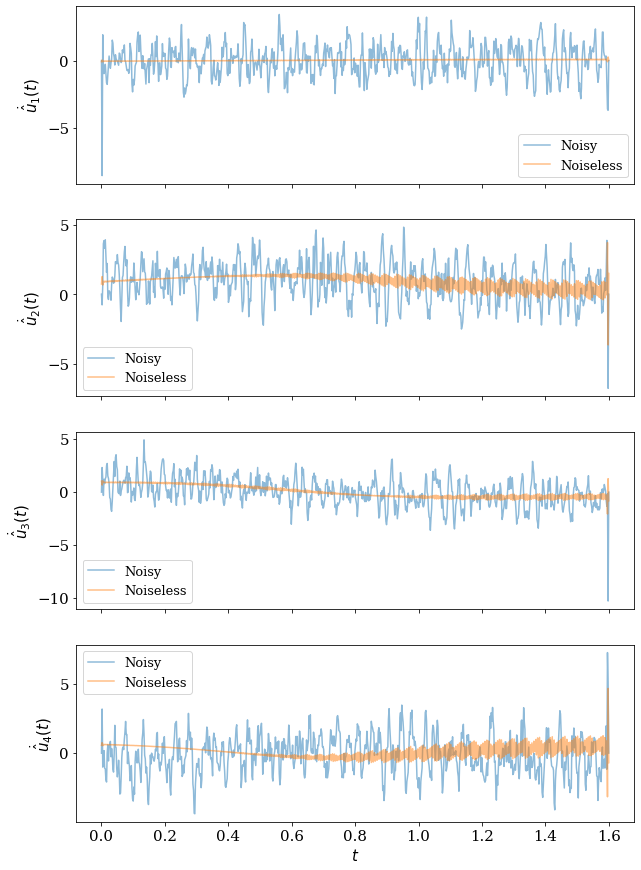

In [46]:
fig, ax = plt.subplots(nrows=rank, sharex=True, figsize=(10, 15))

for ii in range(rank):
    ax[ii].plot(t_vec[:l], Xdot[ii, :], alpha = 0.5, label="Noisy")
    ax[ii].plot(t_vec[:l], Xdot_noiseless[ii, :], alpha=0.5, label="Noiseless")
    ax[ii].set_ylabel(r"$\dot{\hat{u}}_{" + str(ii+1) +"}(t)$", fontsize=15)
    ax[ii].legend()
ax[ii].set_xlabel(r"$t$", fontsize=15)
plt.show()

In [60]:
model = roi.InferredContinuousROM(modelform="AH") # Define the model structure.
model.fit(Vr, Xproj, Xdot, P=regularizer(rank, 1E0, 1E4)) # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.

In [61]:
V_ROM = convert_from_x_to_v(X_ROM)

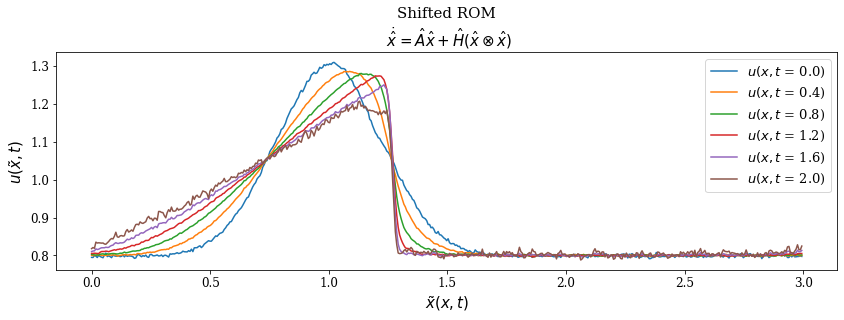

In [62]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, X_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 1)) + ")")
_ = ax.set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
_ = ax.set_ylabel(r"$u(\tilde{x}, t)$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Shifted ROM\n $\dot{\hat x} = \hat{A} \hat{x} + \hat{H} (\hat{x} \otimes \hat{x})$", fontsize=15)
_ = ax.legend()

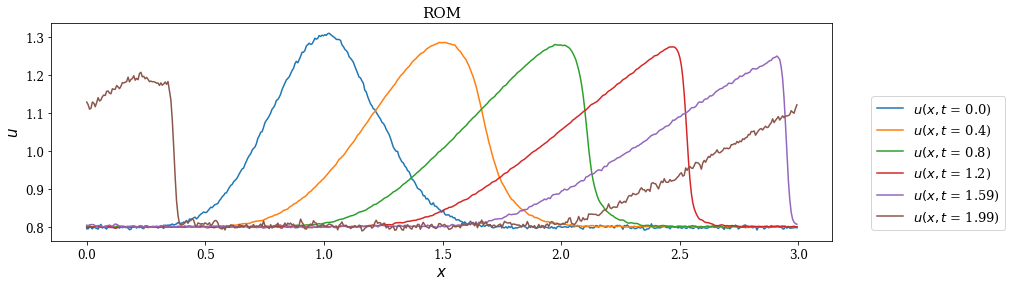

In [63]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, V_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("ROM", fontsize=15)
_ = ax.legend(loc=(1.05, .05))

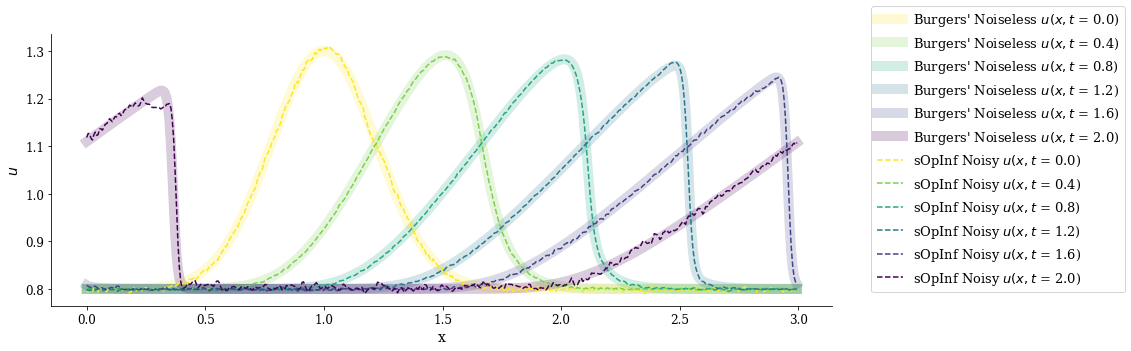

In [51]:
sample_columns = np.arange(0, len(t_vec), int(len(t_vec)//5))
sample_columns = np.append(sample_columns, len(t_vec) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(x_vec, U_sol[:, j], color=curr_color, linewidth=10.0, alpha=0.2,  label="Burgers' Noiseless $u(x, t$ = "+ str(round(t_vec[j], 2)) + ")")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(x_vec, V_ROM[:, j],color=curr_color, ls="--", label="sOpInf Noisy $u(x, t$ = "+ str(round(t_vec[j], 2)) + ")")

ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("$u$", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("Burgers/figs/sopinf_vs_burgers_cce_noise.png", dpi=500, bbox_inches='tight')

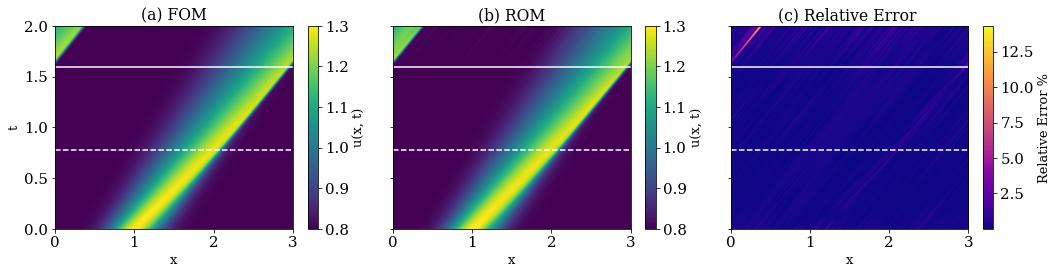

In [52]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(U_sol.T, extent=[a, b,0, T], vmax=0.8, vmin=1.3, aspect="auto", origin="lower")
ax[0].set_xlabel(r"x")
ax[0].set_ylabel(r"t")
ax[0].set_title("(a) FOM")
ax[0].plot(x_vec, t_train[386]* np.ones(len(x_vec)), ls="--", c="white")
ax[0].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('u(x, t)', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[a,b, 0, T], vmax=0.8, vmin=1.3, aspect="auto", origin="lower")
ax[1].set_xlabel(r"x")
ax[1].set_title("(b) ROM")
ax[1].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
ax[1].plot(x_vec, t_train[386]* np.ones(len(x_vec)), ls="--", c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('u(x, t)', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM.T - U_sol.T)/np.abs(U_sol).T, extent=[a,b, 0, T], 
                   cmap="plasma", aspect="auto", origin="lower")
ax[2].set_xlabel(r"x")
ax[2].set_title("(c) Relative Error ")
ax[2].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
ax[2].plot(x_vec, t_train[386]* np.ones(len(x_vec)), ls="--", c="white")
cbar = fig.colorbar(pos, ax=ax[2])

cbar.ax.set_ylabel('Relative Error %', rotation=90)
#plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()
#plt.savefig("Burgers/figs/relative_error_burgers.png")

In [53]:
print("mean relative error = " + "{:.4e}".format(np.mean(np.abs((U_sol - V_ROM))/np.abs(U_sol))))

mean relative error = 2.3090e-03


In [54]:
print("pcc = ", stats.pearsonr(np.ndarray.flatten(U_sol), np.ndarray.flatten(V_ROM))[0])

pcc =  0.9995654071617033


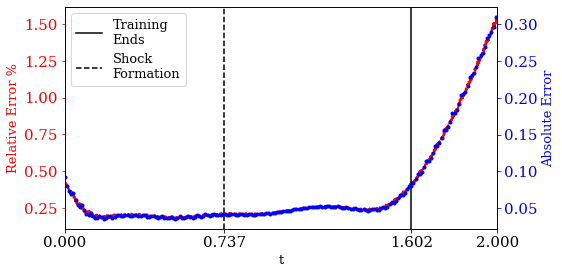

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))
abs_l2err, rel_l2err = roi.post.lp_error(U_sol, V_ROM, p=2)
_ = ax.plot(t_vec, 100*rel_l2err,"--", linewidth=2, c="r")
_ = ax.axvline(t_vec[l], c="k", ls="-",  label="Training\nEnds")
_ = ax.axvline(t_vec[368], c="k", ls="--",  label="Shock\nFormation")
_ = plt.yscale("linear")
_ = ax.set_ylabel("Relative Error %", c="r")
_ = ax.tick_params(axis='y', colors='r')
_ = ax.set_xlim(0, T)
_ = ax.set_xlabel("t")
_ = ax.legend(loc="upper left")
_ = ax.set_xticks([0,  round(t_vec[368], 3),   round(t_vec[l], 3), 2])

ax2=ax.twinx()

_ = ax2.plot(t_vec[::5], abs_l2err[::5], ".", linewidth=2, c="b")
_ = ax2.set_ylabel("Absolute Error", c="b")
_ = ax2.tick_params(axis='y', colors='b')
_ = ax2.set_yscale("linear")
_ = ax2.set_xlim(0, T)
plt.tight_layout()
#plt.savefig("Burgers/figs/ell_2_relative_error.png", dpi=700)

# Optimize free parameters $\lambda_{1}, \lambda_{2}, r$

In [56]:
coeff1_array = 10**np.arange(0, 10)
coeff2_array = 10**np.arange(0, 10)
rank_array = [3, 4]
k_val_array = np.arange(3, 15)

training_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array), len(k_val_array))) * np.inf
testing_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array), len(k_val_array))) * np.inf

In [57]:
for kk, coeff1 in enumerate(coeff1_array):
    for jj, coeff2 in enumerate(coeff2_array):
        for ii, rank_r in enumerate(rank_array):
            for pp, k_val in enumerate(k_val_array):
                Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
                Xproj = Vr.T @ X_train
                Xdot = np.zeros(Xproj.shape)
                for jj in range(0, rank_r):
                    W = ddt_localpoly(n=len(t_train), k=k_val, dt=t_vec[1]-t_vec[0])
                    Xdot[jj, :] = W @ Xproj[jj, :]          
                model = roi.InferredContinuousROM(modelform="AH")              
                model.fit(Vr, Xproj, Xdot, P=regularizer(rank_r, coeff1, coeff2))  
                X_ROM = model.predict(X_train[:, 0], t_vec, method="BDF") 

                if np.shape(X_ROM) == np.shape(X):
                    V_ROM = convert_from_x_to_v(X_ROM)
                    # save training error
                    training_error[kk, jj, ii, pp] = np.max(np.abs(U_noise[:, :l, zeta] - V_ROM[:, :l])/U_noise[:, :l, zeta])
                    # save testing error
                    testing_error[kk, jj, ii, pp] = np.max(np.abs(U_noise[:, l:, zeta] - V_ROM[:, l:])/U_noise[:, l:, zeta])

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve faile

In [58]:
idx  = np.unravel_index(training_error[:, :, :].argmin(), training_error[:, :, :].shape)
print("Training lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Training lambda2 =",  np.log10(coeff2_array[idx[1]]))
print("Training rank =",  rank_array[idx[2]])
print("Training k =",  k_val_array[idx[3]])

Training lambda1 = 3.0
Training lambda2 = 2.0
Training rank = 3
Training k = 3


In [59]:
idx  = np.unravel_index(testing_error[:, :, :].argmin(), testing_error[:, :, :].shape)
print("Testing lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Testing lambda2 =",  np.log10(coeff2_array[idx[1]]))
print("Testing rank =",  rank_array[idx[2]])
print("Testing k =",  k_val_array[idx[3]])

Testing lambda1 = 0.0
Testing lambda2 = 3.0
Testing rank = 4
Testing k = 3
